# LAPD lab - Machine learning project - Model D

This project aims to predict the GHI two hours in advance locally, from meteo data, date data and webcam images.

We are providing a machine learning model to achieve this task.

This model use visual transformers.

## Environnement and dataset definition

### Libraries

First, we import all important packages, data, and set the seed (for torch).


In [8]:
#importing packages
import numpy as np
import pandas as pd
import time
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys
import itertools
import random

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils

from datetime import datetime

from google.colab import files ### file.download() to download a file from colab instead of right clicking

### Seed definition

In an attempt for reproducibility, we define a torch seed for random processes.

In [2]:
# Set fixed random number seed
torch.manual_seed(3174)

### Mounting the drive
You may need to adjust the path according to your needs.

In [18]:
#Mounting Drive
from google.colab import drive
# # # # This will prompt for authorization.
drive.mount("/content/drive")

## change path to where the folder of the images is
path = 'drive/MyDrive/Colab Notebooks/CSS 433/data' #antonin
#path = 'drive/MyDrive/master/CSS 433/data' #Jade
#path = 'drive/MyDrive/data' #Jade ordi 2
#path = 'drive/MyDrive/CSS 433/data' #Alison
sys.path.append(path)
for file in os.listdir(path):
  print(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time.npy
new_irradiance.xlsx
persistent_level.npy
ground_truth.npy
labels.npy
meteo.xlsx
X.npy
labels_only_meteo.xlsx
meteo_data_only.xlsx
iraddiance_raw.xlsx
meteo_time_raw.xlsx
meteo_summary.xlsx
median_Q1_Q3.xlsx
model_Ab.pt
model_D.pt


### Creation of the Dataset

This class allows us to load the dataset and access each element individually.

#### GHIDataset

This dataset allows to retrieve multiple indices at once, hence allowing to load consecutive samples.

In [5]:
class GHIDataset(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, labels, images, meteo, GHI, time, transform_images=None, transform_label=None, normalise_meteo=False):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            labels    (string) : Name of the file with labels.
            images    (string) : Name of the file with images.
            meteo     (string) : Name of the file with the meteo data
            GHI       (string) : Name of the file with the GHI (ground truth)
            time      (string) : Name of the file with the time at which the data (meteo and images) has been acquired
            transform_images (callable, optional): Optional transform to be applied to the images.
            transform_label  (callable, optional): Optional transform to be applied to the label.
            transform_meteo  (bool, optional)    : Optional normalisation to be applied to the meteo data.
        """


        self.root_dir = root_dir
        self.labels = torch.from_numpy(np.load(os.path.join(self.root_dir,labels))).to(torch.float32)
        self.images = np.load(os.path.join(self.root_dir,images),mmap_mode='c')

        # Define the transforms to apply to labels or input
        self.transform_images = transform_images
        self.transform_label = transform_label
        self.normalise_meteo = normalise_meteo

        self.GHI =  torch.from_numpy(np.load(os.path.join(path, GHI),allow_pickle=True)).to(torch.float32)

        df = pd.read_excel(os.path.join(self.root_dir, meteo))

        time_image = np.load(os.path.join(self.root_dir, time),allow_pickle=True)

        # Extract day, month, and year using list comprehension
        date = [(dt.day, dt.month, dt.year, dt.hour, dt.minute) if isinstance(dt, datetime) else
         (datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').minute)
         for dt in time_image]

        # Transpose the list of tuples using zip
        day_, month_, year_, hour_, minute_ = zip(*date)

        # Convert the individual columns to PyTorch tensors and normalise if required
        if normalise_meteo:
          self.day = torch.tensor(preprocessing.normalize([day_])[0])
          self.month = torch.tensor(preprocessing.normalize([month_])[0])
          self.year = torch.tensor(preprocessing.normalize([year_])[0])
          self.hour = torch.tensor(preprocessing.normalize([hour_])[0])
          self.minute = torch.tensor(preprocessing.normalize([minute_])[0])
          self.air_temp = torch.from_numpy(preprocessing.normalize([df['Air_temp'].values])[0])
          self.wind_speed = torch.from_numpy(preprocessing.normalize([df['Wind_speed'].values])[0])
          self.wind_dir = torch.from_numpy(preprocessing.normalize([df['Wind_dir'].values])[0])
        else:
          self.day = torch.tensor(day_)
          self.month = torch.tensor(month_)
          self.year = torch.tensor(year_)
          self.hour = torch.tensor(hour_)
          self.minute = torch.tensor(minute_)
          self.air_temp = torch.from_numpy(df['Air_temp'].values)
          self.wind_speed = torch.from_numpy(df['Wind_speed'].values)
          self.wind_dir = torch.from_numpy(df['Wind_dir'].values)

    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Import from memory only the data (images, meteo, GHI and time) that we want
        image0 = np.array(self.images[idx,0])
        image1 = np.array(self.images[idx,1])
        labels = self.labels[idx]

        GHI = self.GHI[idx]
        day = self.day[idx]
        month = self.month[idx]
        year = self.year[idx]
        hour = self.hour[idx]
        minute = self.minute[idx]
        air_temp = self.air_temp[idx]
        wind_speed = self.wind_speed[idx]
        wind_dir = self.wind_dir[idx]

        meteo_data = torch.stack((day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir),dim=1).to(torch.float32)
        # Apply the transforms
        if self.transform_images:
          image0_transformed = []
          image1_transformed = []
          for image in image0:
            image0_transformed.append(self.transform_images(image))
          for image in image1:
            image1_transformed.append(self.transform_images(image))

        if self.transform_label:
            labels = self.transform_label(labels)

        data = (torch.stack(image0_transformed),torch.stack(image1_transformed),meteo_data,labels)

        return data

Below we load the dataset and transfom the images.

#### Dataset Creation

In [6]:
# Set the desired size of the image
img_size = 100

# The following line creates a transform which converts the np.array to a PIL Image.
# It then resizes the image to img_size x img_size and converts the image to a tensor

transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize(img_size),transforms.ToTensor()])

# Generate the dataset containing all the samples
#ghi_dataset = GHIDataset(path,'labels.npy','X.npy','meteo.xlsx','ground_truth.npy','time.npy',transform)
ghi_dataset = GHIDataset(path,'labels.npy','X.npy','meteo.xlsx','ground_truth.npy','time.npy',transform)

#### Separation Functions

In [9]:
def split_at_location(dataset, location = 0, length = 100):
    """
      This function allows to extract the test or validation set at a given location in the dataset
        Arguments:
            location  (int) : position in the dataset where the test/validation set will start
            length    (int) : length of the test/validation set
        """
    # Initialise the indices of the dataset
    dataset_idx = np.arange(len(dataset))
    # Compute start and stop indices of the test/validation set while preventing out-of-range targets
    start_idx = max(0,location)
    end_idx = min(len(dataset),location+length)
    validation_idx = dataset_idx[start_idx:end_idx]

    # Compute the indices of the training set by removing the ones of the test/validation set.
    train_idx = np.concatenate([dataset_idx[:start_idx], dataset_idx[end_idx:]])

    # Return the two sets
    return Subset(dataset, train_idx), Subset(dataset, validation_idx)

def train_val_dataset(dataset,test_split=0.8, val_split=0.2):
    """
      split dataset in train set, validation set, test set
    """

    test_idx, train_idx = train_test_split(list(range(len(dataset))), test_size=test_split,shuffle=False)
    train_idx, val_idx = train_test_split(train_idx,test_size=val_split,shuffle=False)

    return Subset(dataset, train_idx), Subset(dataset, val_idx), Subset(dataset, test_idx)

def shuffle(dataset) :
  """
      This function allows to shuffle the data in the given set
  """

  data_idx = np.arange(len(dataset))
  random.shuffle(data_idx)
  #print(data_idx)
  return Subset(dataset, data_idx)


#### Choose our validation set

In [10]:
location1 = 1270
location2 = 4000 - 400
location3 = 7900 - 800

ghi_train, ghi_test1 = split_at_location(ghi_dataset, location1, 400)
ghi_train, ghi_test2 = split_at_location(ghi_train, location2, 400)
ghi_train, ghi_test3 = split_at_location(ghi_train, location3, 400)

ghi_test = ghi_test1 + ghi_test2 + ghi_test3
print("Train set of size      : ", len(ghi_train))
print("Validation set of size : ",len(ghi_test))

# below : in case of only one validation set, no cross validation

#ghi_train ,ghi_val= split_at_location(ghi_train, 0, round(len(ghi_train)*0.10))

#define the loader !
#train_loader = DataLoader(ghi_train, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_train)), batch_size=32, dec = 32))
#test_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_test)), batch_size=32, dec = 32))


Train set of size      :  9493
Validation set of size :  1200


## Definition of dataloaders

Finally we create the dataloader, to iterate on it as we compute each epoch.

We define a custom batch sampler because we need to conserve the order of the samples in each batch. Moreover, we want the stride (dec) between each batch to be customizable and not the batch size. Such that for a dataset = [1,2,3,4,5,6] and a batch size of 3 we get [1,2,3], [2,3,4], [3,4,5], [4,5,6] as batches

#### Sequencer 1

In [ ]:
class SequentialBatchSampler:
    def __init__(self, data_source, batch_size, dec):
        self.data_source = data_source
        self.batch_size = batch_size
        self.dec = dec

    def __iter__(self):
      i = 0
      while i <= len(self.data_source)-self.batch_size-1:
        #print(self.data_source[i:i+self.batch_size].dtype)
        yield [self.data_source[i:i+self.batch_size]]
        i += self.dec

#### Sequencer 2

In [11]:
class SequentialBatchSampler2:
    def __init__(self, data_source, batch_size, L,validation = False):
        self.data_source = data_source
        self.batch_size = batch_size
        self.L = L
        self.validation = validation

    def __iter__(self):
      indices = np.arange(len(self.data_source)-self.L)+self.L #if we use the last 4 images, we need to take out the first 4 images
      #note for later -> this is assuming we have continuous train data ! we should use a preprocessing step to look at the continuity
      #to enter only the data when the following 4 ,data is good
      if not self.validation:
        np.random.shuffle(indices)
      batch = []
      for idx in indices:
        sample = self.data_source[idx-self.L:idx]
        batch.append(sample)
        if len(batch) == self.batch_size:
          yield batch
          batch = []

# Model

we defined and tested several vit transformer based on [ViT-pytorch](https://github.com/lucidrains/vit-pytorch).


### Network Definition

In [12]:
!pip install vit-pytorch
from vit_pytorch import ViT
from vit_pytorch import SimpleViT
from vit_pytorch.t2t import T2TViT
from vit_pytorch.cct import CCT
from vit_pytorch.regionvit import RegionViT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.8 MB/s eta 0:00:00


In [13]:
v = ViT(
    image_size = 100,
    patch_size = 10,
    num_classes = 1,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

v2 = SimpleViT(
    image_size = 100,
    patch_size = 10,
    num_classes = 1,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
)

v3 = T2TViT(
    dim = 512,
    image_size = 224,
    depth = 5,
    heads = 8,
    mlp_dim = 512,
    num_classes = 1000,
    t2t_layers = ((7, 4), (3, 2), (3, 2)) # tuples of the kernel size and stride of each consecutive layers of the initial token to token module
)

cct = CCT(
    img_size = (224, 448),
    embedding_dim = 384,
    n_conv_layers = 2,
    kernel_size = 7,
    stride = 2,
    padding = 3,
    pooling_kernel_size = 3,
    pooling_stride = 2,
    pooling_padding = 1,
    num_layers = 14,
    num_heads = 6,
    mlp_ratio = 3.,
    num_classes = 1000,
    positional_embedding = 'learnable', # ['sine', 'learnable', 'none']
)

model = RegionViT(
    dim = (64, 128, 256, 512),      # tuple of size 4, indicating dimension at each stage
    depth = (2, 2, 8, 2),           # depth of the region to local transformer at each stage
    window_size = 7,                # window size, which should be either 7 or 14
    num_classes = 1000,             # number of output classes
    tokenize_local_3_conv = False,  # whether to use a 3 layer convolution to encode the local tokens from the image. the paper uses this for the smaller models, but uses only 1 conv (set to False) for the larger models
    use_peg = False,                # whether to use positional generating module. they used this for object detection for a boost in performance
)

In [14]:
class Vision(nn.Module):

    def __init__(self):
      super(Vision, self).__init__()
      self.V1 = ViT(
          image_size=100,
          patch_size=10,
          num_classes=32,
          dim=512,
          depth=6,
          heads=8,
          mlp_dim=1024,
          dropout=0.1,
          emb_dropout=0.1
        )

      self.V2 = ViT(
          image_size=100,
          patch_size=10,
          num_classes=32,
          dim=512,  # Reduced from 1024
          depth=6,
          heads=8,  # Reduced from 16
          mlp_dim=1024,  # Reduced from 2048
          dropout=0.1,
          emb_dropout=0.1
        )

      #self.additional_fc1 = nn.Linear(9, 64)  # if meteo before
      self.fc1 = nn.Linear(64, 64)
      self.fc2 = nn.Linear(64, 1)
      #self.fc2 = nn.Linear(64+9, 1) # if meteo after

    def forward(self, x1,x2,meteo_data): #x1 and x2 correspond to the 2 images
        vision1 = self.V1(x1.squeeze(1))
        vision2 = self.V2(x2.squeeze(1))
        x = torch.cat((vision1, vision2), dim=1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc1(x))

        #if meteo before
        #x_add = F.relu(self.additional_fc1(meteo_data.squeeze(1))) #add meteo data
        #x = torch.cat((x, x_add), dim=1)

        #if meteo after
        #x = torch.cat((x, meteo_data.squeeze(1)), dim=1)

        x = self.fc2(x) # add relu because not 0
        x = x.squeeze()
        return x

# Training

### Training / Validation Functions

In [15]:
def RMSELoss(yhat,y): #defining RMSE
    return torch.sqrt(torch.mean((yhat-y)**2))

def reset_weights(m,verbose=False):
  '''
    Method to reset the model weights between each fold or utilization
    Avoid weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    if verbose:
      print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
  """
    method to train the model on a given training set
    return the loss at each step
  """
  # Set model to training mode (affects dropout, batch norm e.g.)
  model.train()
  loss_history = []
  lr_history = []
  # loop to get batch_idx, data and target from train_loader
  for batch_idx, data in enumerate(train_loader):
      # Move the data to the device
      data = list(feature.to(device) for feature in data)

      # The last element of the list data is the target so we remove it for the model
      target = data.pop()

      # Zero the gradients
      optimizer.zero_grad()

      # Compute model output
      # The input data is all the elements of the list data except the last

      #x1, x2, meteo = data
      #x1 = x1.squeeze(1) #for v1 !

      output = model(*data)

      #output = model(x1) #for v1
      # Compute loss

      #loss = criterion(output[...,-1], target[...,-1])
      loss = criterion(output, target[...,-1])
      # Backpropagate loss
      loss.backward()
      # Perform an optimizer step
      optimizer.step()
      scheduler.step()
      # Compute loss (float value, not a tensor)
      loss_float = loss.item()
      loss_history.append(loss_float)
  print(
    f"Train Epoch : {epoch}"
    f"train_loss = {np.sqrt(np.mean(loss_history))} "
  )

  return loss_history

@torch.no_grad()
def validate(model, device, val_loader, criterion):
  """
    method to validate the model on a given validation set
    return the loss at each step
  """
  model.eval()  # Important: eval mode (affects dropout, batch norm etc)
  test_loss = 0
  history = []

  for data in val_loader:
    data = list(feature.to(device) for feature in data)
    target = data.pop()
    #x1, x2, meteo = data
    #x1 = x1.squeeze(1)
    output = model(*data)
    #output = model(x1)

    #test_loss = criterion(output[...,-1], target[...,-1]).item()
    test_loss = criterion(output, target[...,-1]).item()
    history.append(test_loss)

  print(
    "Test set: Average loss: {:.4f}".format(
       np.sqrt(np.mean(history)),
       len(val_loader.dataset)
      )
  )
  return history

# Final model


### Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ==== Parameters for training ====

# Optimizer parameters
optimizer_kwargs = dict( # how did you decice that ?
    lr=5e-4,
    weight_decay=1e-3,
)

# Model initialization
model = Vision()
model = model.to(device=device)
model.apply(reset_weights)

# Optimizer initialization
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)

# Criterion for the training
criterion = F.mse_loss

# Parameters for dataloaders and epochs
num_epochs = 20
batch = 8
L = 1

# Dataloaders creation
train_loader = DataLoader(ghi_train, batch_sampler=SequentialBatchSampler2(np.arange(len(ghi_train)),L=L,batch_size=batch))
val_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler2(np.arange(len(ghi_test)),L=L,batch_size=batch,validation= True))

# Scheduler creation
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // batch,)

# ===== Train Model =====
train_loss_history = []
train_loss_step = []
val_loss_history = []
val_loss_step = []
best_val_loss = float('inf')
best_epoch = 0
for epoch in range(1, num_epochs + 1):
  print("Epoch : ",epoch,"/",num_epochs)
  train_loss = train_epoch(model, optimizer,scheduler, criterion, train_loader, epoch, device)
  train_loss_history.extend(train_loss)
  train_loss_step.append(np.sqrt(np.mean(train_loss)))

  val_loss = validate(model, device, val_loader, criterion)
  val_loss_history.extend(val_loss)
  val_loss = np.sqrt(np.mean(val_loss))
    #val_loss_history.extend(val_loss)
  val_loss_step.append(val_loss)

    # Save the model with the lowest validation loss
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_epoch = epoch
    best_model_state = model.state_dict()

last_model = model.state_dict()

loading
loading ok
Epoch :  1 / 20
Train Epoch : 1train_loss = 194.20585286879486 
Test set: Average loss: 113.4229
Epoch :  2 / 20
Train Epoch : 2train_loss = 132.74079418874948 
Test set: Average loss: 98.2319
Epoch :  3 / 20
Train Epoch : 3train_loss = 129.94823752501657 
Test set: Average loss: 119.1851
Epoch :  4 / 20
Train Epoch : 4train_loss = 129.47380771057743 
Test set: Average loss: 115.4734
Epoch :  5 / 20
Train Epoch : 5train_loss = 123.10715460629397 
Test set: Average loss: 94.3588
Epoch :  6 / 20
Train Epoch : 6train_loss = 121.45162350507788 
Test set: Average loss: 93.8830
Epoch :  7 / 20
Train Epoch : 7train_loss = 119.76757642382707 
Test set: Average loss: 93.4983
Epoch :  8 / 20
Train Epoch : 8train_loss = 117.45582524994066 
Test set: Average loss: 89.8606
Epoch :  9 / 20
Train Epoch : 9train_loss = 115.48227662342939 
Test set: Average loss: 94.1575
Epoch :  10 / 20
Train Epoch : 10train_loss = 114.55818552013717 
Test set: Average loss: 90.2029
Epoch :  11 / 20

best loss 84.49724630931881 epoch 16


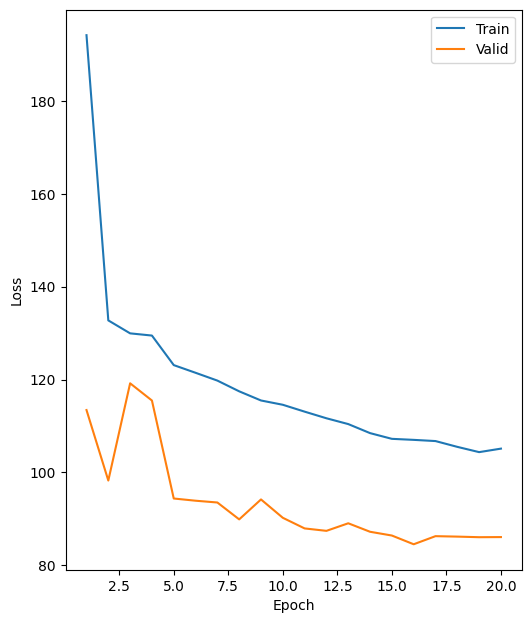

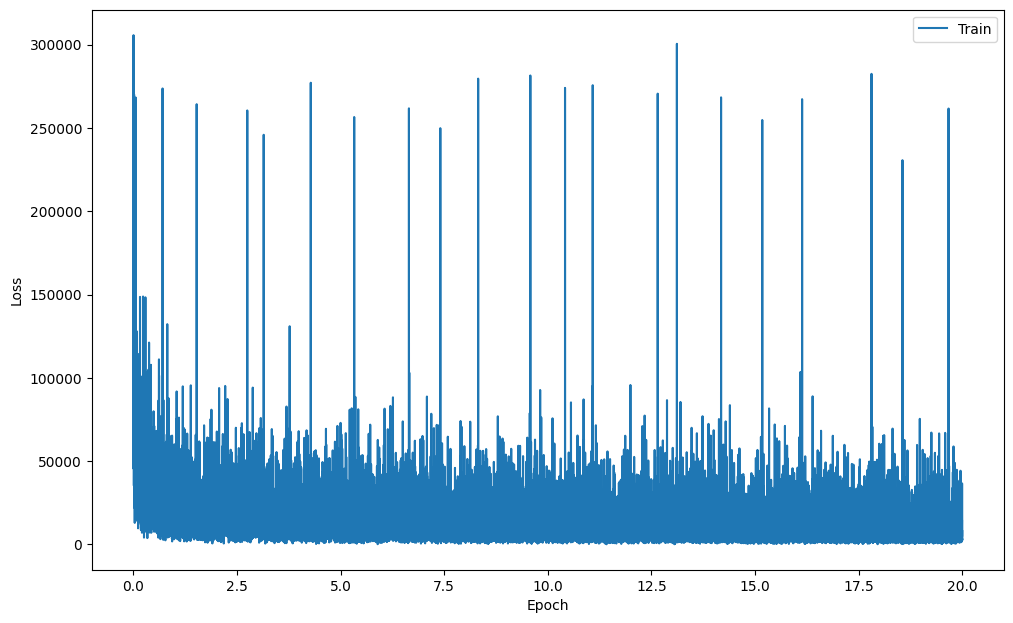

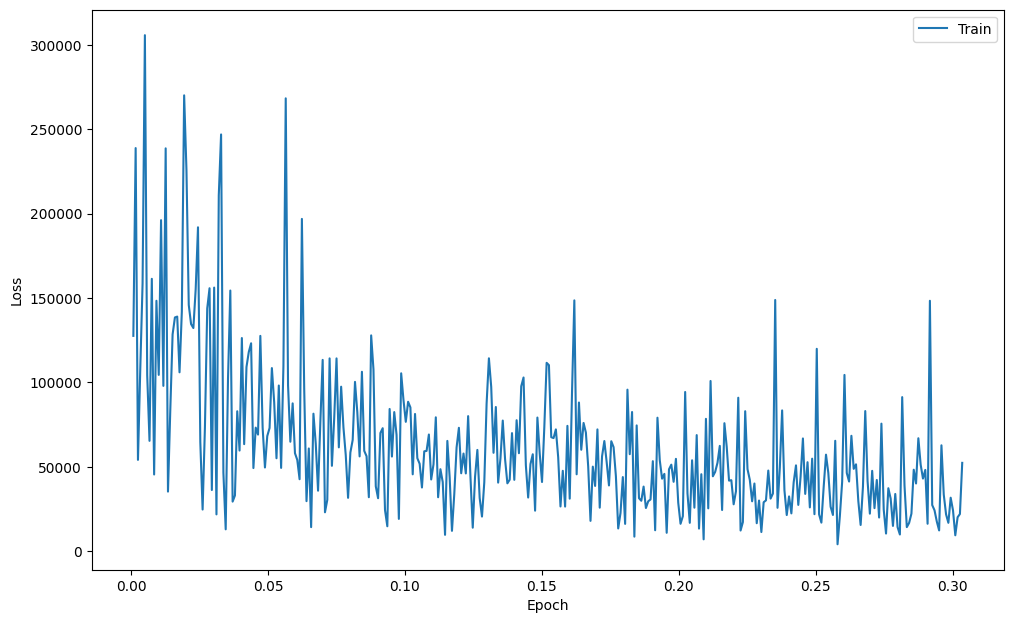

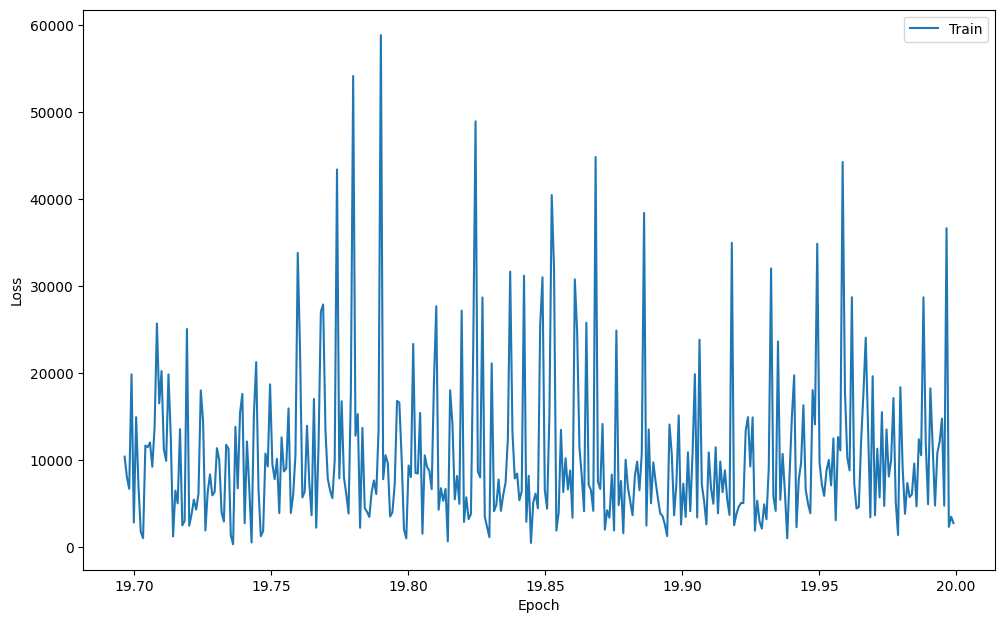

In [ ]:
# ===== Plot training curves =====
t_val = np.arange(1, num_epochs + 1)

# Increase the size of the plot
plt.figure(figsize=(20, 16))

plt.subplot(2, 3, 2)
plt.plot(t_val, train_loss_step, label="Train")
plt.plot(t_val, val_loss_step, label="Valid")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Increase the size of the plot
plt.figure(figsize=(40, 16))

t_train = np.arange(1, len(train_loss_history) + 1)/len(train_loss_history)*num_epochs

plt.subplot(2, 3, 2)
plt.plot(t_train, train_loss_history, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()


# Increase the size of the plot
plt.figure(figsize=(40, 16))


plt.subplot(2, 3, 2)
plt.plot(t_train[0:360], train_loss_history[0:360], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Increase the size of the plot
plt.figure(figsize=(40, 16))

plt.subplot(2, 3, 2)
plt.plot(t_train[-361:-1], train_loss_history[-361:-1], label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

This code can be executed to save the model for later inferences.

In [ ]:
model.load_state_dict(best_model_state)

model_filename = 'model_D.pt'
torch.save(model.state_dict(), os.path.join(path, model_filename))

This code can be executed to load the model for inferences.

In [19]:
model = Vision()
model_filename = 'model_D.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load(os.path.join(path, model_filename),map_location=torch.device(device)))

<All keys matched successfully>

the test loss is  96.51929468712932


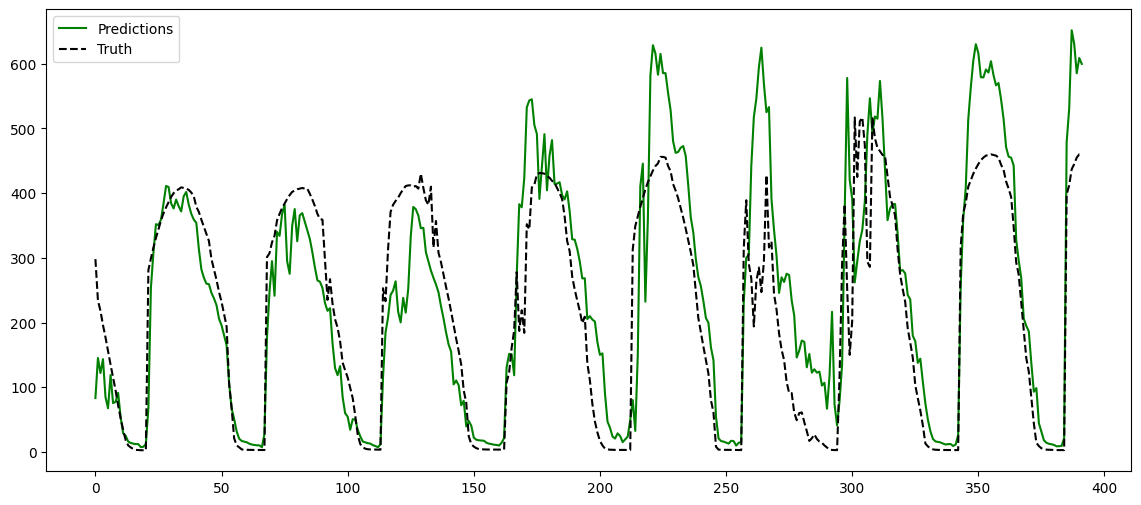

the test loss is  47.487298877650275


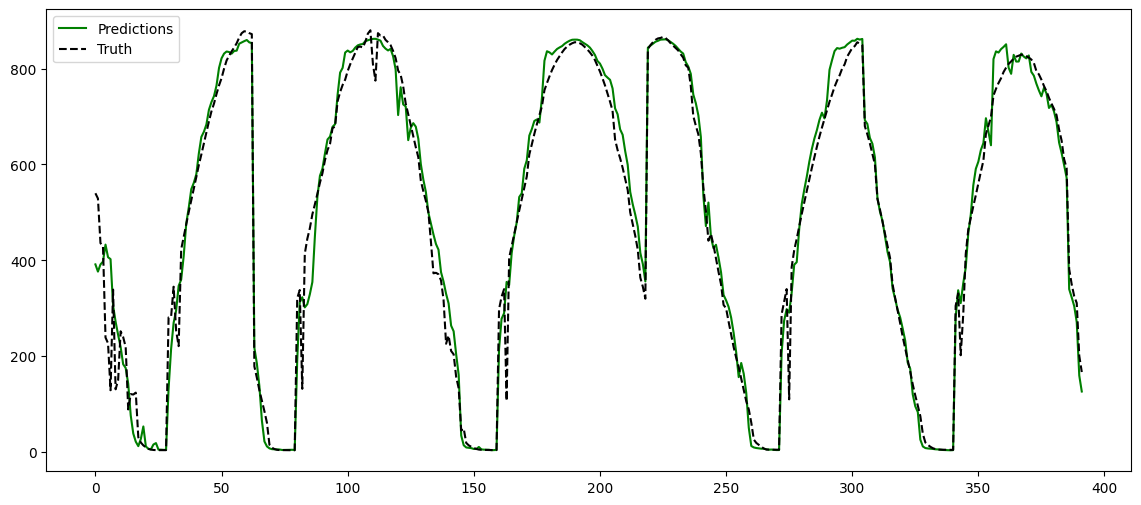

the test loss is  103.76998510034971


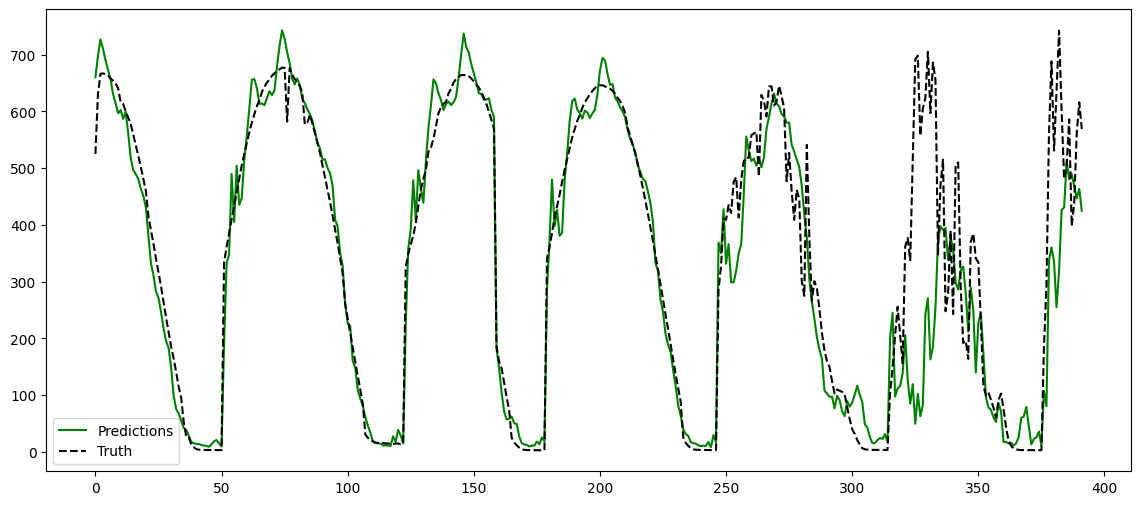

In [21]:
batch = 8
L = 1
criterion = F.mse_loss
# ===== Validation Set 1 =====
# Creation of the test loader
test_loader = DataLoader(ghi_test1, batch_sampler=SequentialBatchSampler2(np.arange(len(ghi_test1)),L=L,batch_size=batch,validation= True))

pred1 = []
truth1 = []
test_loss = []
model.eval()
past = 0
date_past = 0

# Validation
for data in test_loader:
  data = list(feature.to(device) for feature in data)
  target = data.pop()

  output = model(*data)

  pred1.extend(output.tolist())
  truth1.extend(target[...,-1].tolist())
  #test_loss.append(criterion(output[...,-1], target[...,-1]).item())
  test_loss.append(criterion(output, target[...,-1]).item())

  past = output[-1]


Loss = np.sqrt(np.mean(test_loss))
#print(len(pred),len(truth))
print("the test loss is ",Loss)

# Plot the results
plt.figure(figsize=(14,6))
plt.plot(pred1, 'g', label = "Predictions")
plt.plot(truth1, '--k',label = 'Truth')
plt.legend(loc = 'best')
plt.show()


# ===== Validation Set 2 =====
# Creation of the test loader
test_loader = DataLoader(ghi_test2, batch_sampler=SequentialBatchSampler2(np.arange(len(ghi_test2)),L=1,batch_size=batch,validation= True))

pred2 = []
truth2 = []
test_loss = []
model.eval()
past = 0
date_past = 0

# Validation
for data in test_loader:
  data = list(feature.to(device) for feature in data)
  target = data.pop()

  output = model(*data)

  pred2.extend(output.tolist())
  truth2.extend(target[...,-1].tolist())
  #test_loss.append(criterion(output[...,-1], target[...,-1]).item())
  test_loss.append(criterion(output, target[...,-1]).item())
  past = output[-1]


Loss = np.sqrt(np.mean(test_loss))
#print(len(pred),len(truth))
print("the test loss is ",Loss)

# Plot the results
plt.figure(figsize=(14,6))
plt.plot(pred2, 'g', label = "Predictions")
plt.plot(truth2, '--k',label = 'Truth')
plt.legend(loc = 'best')
plt.show()


# ===== Validation Set 2 =====
# Creation of the test loader
test_loader = DataLoader(ghi_test3, batch_sampler=SequentialBatchSampler2(np.arange(len(ghi_test3)),L=1,batch_size=batch,validation= True))

pred3 = []
truth3 = []
test_loss = []
model.eval()
past = 0
date_past = 0

# Validation
for data in test_loader:
  data = list(feature.to(device) for feature in data)
  target = data.pop()

  output = model(*data)

  pred3.extend(output.tolist())
  truth3.extend(target[...,-1].tolist())
  test_loss.append(criterion(output, target[...,-1]).item())
  #test_loss.append(criterion(output[...,-1], target[...,-1]).item())
  past = output[-1]


Loss = np.sqrt(np.mean(test_loss))
#print(len(pred),len(truth))
print("the test loss is ",Loss)

# Plot the results
plt.figure(figsize=(14,6))
plt.plot(pred3, 'g', label = "Predictions")
plt.plot(truth3, '--k',label = 'Truth')
plt.legend(loc = 'best')
plt.show()

This cell allows to save the results to allow comparison with other models.

In [ ]:
import pickle

# Combine lists into a dictionary
data = {'dataset1': pred1, 'dataset2': pred2, 'dataset3': pred3}

# Specify the file path
file_path = os.path.join(path, 'model_D.pkl')

# Save the dictionary to a file
with open(file_path, 'wb') as file:
    pickle.dump(data, file)

print(f"Lists saved to {file_path}")

Lists saved to drive/MyDrive/master/CSS 433/data/model_D.pkl
